# Capstone Project Brief

This Capstone Project is part of the <u>5-day Gen AI Intensive Course with Google</u>, which took place from Monday March 31 - Friday April 4, 2025. This project seek to apply what we learned from the course to a real world use case/problem, and achive the following Gen AI capabilities: Gen AI document/image understanding, Data embedding into a vector database in a searchable way (Retrieval augmented generation, or RAG), Structured output/JSON mode/controlled generation, Few-shot prompting, function calling, etc.

In addition to this public Kaggle notebook, this project also included a blogpost and a Youtube video that dive further into the background and the problem this project is responding to, as well as use cases of the proposed solution, next steps, etc.

## Project Problem Statement

The Architecture, Engineering, and Construction (AEC) industry has historically been among the slowest sectors to adopt advanced digital technologies. Many firms lack the necessary infrastructure and technical expertise to develop robust in-house data pipelines and effective knowledge management systems. Consequently, valuable information—such as project documentation, design standards, and lessons learned—often remains siloed across disparate systems and departments. This fragmentation hampers efficient knowledge retrieval, leading to redundant efforts, increased risk of errors, and missed opportunities for innovation.

## Proposed Solution

To address these challenges, we propose developing a proof-of-concept system utilizing Retrieval-Augmented Generation (RAG) technology. This system will integrate semantic search capabilities with generative AI to enable users to query and access relevant information from the organization’s existing knowledge base effectively. By leveraging RAG, the solution aims to:
- Break down information silos by unifying access to diverse data sources.
- Enhance decision-making by providing contextually relevant insights.
- Improve operational efficiency through rapid information retrieval.

## Project Setup

Before we begin, we’ll configure the environment by installing required libraries and cleaning up unused packages from Kaggle’s default environment.

- We’ll first remove unused or conflicting packages from the Kaggle base image to avoid version conflicts.
- we’ll install the core libraries needed for this project
    - Google generative AI sdk for AI generation
    - A Google AI API key to access Gemini from this notebook
    - ChromaDB for vector store and search
    - Langchain for agentic actions
    - Markdown metadata processing with python-frontmatter library
    - tqdm for progress bar support as we will be processing large chunks of data through gen AI that could take a while

In [30]:
# Remove conflicting/unused packages from the Kaggle base environment.
!pip uninstall -qqy jupyterlab kfp libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
# Install Google AI API
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"
# Library to process markdown frontmatter for metadata
!pip install python-frontmatter 
#adding progress bar support
!pip install tqdm 

In [31]:
# import the google genai library and tools to support tweaking its configurations
from google import genai
from google.genai import types

# import Markdown for visualizing generated text in a structured and visualling pleasing way
from IPython.display import Markdown

# testing to confirm the correct version of genai is installed
genai.__version__

'1.7.0'

In [32]:
# load the API key
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

## Explore available models

### Embedding Model

We will be using the [`embedContent`](https://ai.google.dev/api/embeddings#method:-models.embedcontent) API method to calculate embeddings of documents before saving to the database. 

- `text-embedding-004` is the most recent generally-available embedding model
- experimental `gemini-embedding-exp-03-07` model
- more info: [`models.list`](https://ai.google.dev/api/models#method:-models.list) / [the models page](https://ai.google.dev/gemini-api/docs/models/gemini#text-embedding).

### LLM Model
We will also list all generation models below and check their capabilities. We will chose `gemini-2.0-flash` for this project because it offers fast, cost-efficient performance, and its 1 million token context window is well-suited for surfacing insights from fragmented documents from various sources in a RAG framework. Its support for multimodal inputs also provides future flexibility as AEC data often includes images and schematics. 

In [33]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for m in client.models.list():
    if "embedContent" in m.supported_actions:
        print(m.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


In [34]:
# Collect rows of model info
rows = [
    "| Model | Supported Actions |",
    "|-------|-------------------|"
]

for m in client.models.list():
    name = m.name
    actions = m.supported_actions

    is_embedding = "embedContent" in actions

    # Skip embedding models if desired
    if not is_embedding:
        actions_str = ", ".join(actions)
        row = f"| `{name}` | {actions_str} |"
        rows.append(row)

# Display the markdown table
display(Markdown("\n".join(rows)))

| Model | Supported Actions |
|-------|-------------------|
| `models/chat-bison-001` | generateMessage, countMessageTokens |
| `models/text-bison-001` | generateText, countTextTokens, createTunedTextModel |
| `models/embedding-gecko-001` | embedText, countTextTokens |
| `models/gemini-1.0-pro-vision-latest` | generateContent, countTokens |
| `models/gemini-pro-vision` | generateContent, countTokens |
| `models/gemini-1.5-pro-latest` | generateContent, countTokens |
| `models/gemini-1.5-pro-001` | generateContent, countTokens, createCachedContent |
| `models/gemini-1.5-pro-002` | generateContent, countTokens, createCachedContent |
| `models/gemini-1.5-pro` | generateContent, countTokens |
| `models/gemini-1.5-flash-latest` | generateContent, countTokens |
| `models/gemini-1.5-flash-001` | generateContent, countTokens, createCachedContent |
| `models/gemini-1.5-flash-001-tuning` | generateContent, countTokens, createTunedModel |
| `models/gemini-1.5-flash` | generateContent, countTokens |
| `models/gemini-1.5-flash-002` | generateContent, countTokens, createCachedContent |
| `models/gemini-1.5-flash-8b` | createCachedContent, generateContent, countTokens |
| `models/gemini-1.5-flash-8b-001` | createCachedContent, generateContent, countTokens |
| `models/gemini-1.5-flash-8b-latest` | createCachedContent, generateContent, countTokens |
| `models/gemini-1.5-flash-8b-exp-0827` | generateContent, countTokens |
| `models/gemini-1.5-flash-8b-exp-0924` | generateContent, countTokens |
| `models/gemini-2.5-pro-exp-03-25` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.5-pro-preview-03-25` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.5-flash-preview-04-17` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-flash-exp` | generateContent, countTokens, bidiGenerateContent |
| `models/gemini-2.0-flash` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-flash-001` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-flash-exp-image-generation` | generateContent, countTokens, bidiGenerateContent |
| `models/gemini-2.0-flash-lite-001` | generateContent, countTokens |
| `models/gemini-2.0-flash-lite` | generateContent, countTokens |
| `models/gemini-2.0-flash-lite-preview-02-05` | generateContent, countTokens |
| `models/gemini-2.0-flash-lite-preview` | generateContent, countTokens |
| `models/gemini-2.0-pro-exp` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-pro-exp-02-05` | generateContent, countTokens, createCachedContent |
| `models/gemini-exp-1206` | generateContent, countTokens, createCachedContent |
| `models/gemini-2.0-flash-thinking-exp-01-21` | generateContent, countTokens |
| `models/gemini-2.0-flash-thinking-exp` | generateContent, countTokens |
| `models/gemini-2.0-flash-thinking-exp-1219` | generateContent, countTokens |
| `models/learnlm-1.5-pro-experimental` | generateContent, countTokens |
| `models/learnlm-2.0-flash-experimental` | generateContent, countTokens |
| `models/gemma-3-1b-it` | generateContent, countTokens |
| `models/gemma-3-4b-it` | generateContent, countTokens |
| `models/gemma-3-12b-it` | generateContent, countTokens |
| `models/gemma-3-27b-it` | generateContent, countTokens |
| `models/aqa` | generateAnswer |
| `models/imagen-3.0-generate-002` | predict |
| `models/gemini-2.0-flash-live-001` | bidiGenerateContent, countTokens |

## Data Preparation

Loading a list of documents we can use to create an embedding database to retrieve from.

### Data Source:
Here we are using a list of markdown articles sourced from Gensler.com dialogue blog 2025<br>
**Public Gensler Thought Leadership:** https://www.kaggle.com/datasets/junwangzero/public-gensler-thought-leadership

In [53]:
import os

dataset_name = "public-gensler-thought-leadership"
input_path = f"/kaggle/input/{dataset_name}"
all_files = []

# Directly walk through the single dataset folder
for root, dirs, files in os.walk(input_path):
    for file in files:
        all_files.append(os.path.join(root, file))


# Print total count and the list
print(f"Total number of files: {len(all_files)}\n")
for file_path in all_files:
    print(file_path)
Markdown('---')

Total number of files: 34

/kaggle/input/public-gensler-thought-leadership/The New Experiential Hybrid.md
/kaggle/input/public-gensler-thought-leadership/The Biggest Challenge to Office Conversions Isnt Design  Its the Status Quo.md
/kaggle/input/public-gensler-thought-leadership/Realizing the Value of Artificial Intelligence When Planning Tomorrows Healthcare Facilities.md
/kaggle/input/public-gensler-thought-leadership/Global Workplace Survey Comparison 2023.md
/kaggle/input/public-gensler-thought-leadership/Prototyping the Hospital of the Future.md
/kaggle/input/public-gensler-thought-leadership/Redefining the Workplace for a New Era of Productivity and Engagement.md
/kaggle/input/public-gensler-thought-leadership/Severe Weather The New Design Imperative.md
/kaggle/input/public-gensler-thought-leadership/The Uncertainty of Electric Power A View from Houston.md
/kaggle/input/public-gensler-thought-leadership/Biodiversity as the New Frontier for Achieving Resilience in Real Estate.md


---

We can visualize the format of a sample article:

In [36]:
# helper function to parse input markdown files
def read_markdown(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()

# Read all markdown files into a list of strings
documents = [read_markdown(path) for path in all_files]

print(documents[0][:800])  # Preview first 500 characters of the first doc
Markdown('---')

---
title: "The New Experiential Hybrid"
source: "https://www.gensler.com/blog/the-new-experiential-hybrid"
author:
  - "[[Gensler]]"
published:
created: 2025-04-09
description: "Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME."
tags:
  - "clippings"
---
![A street with cars and buildings.](https://static2.gensler.com/uploads/image/96476/Sportsmens_Lodge_N7_1738969737.jpg)

The Sportsmen’s Lodge, Los Angeles, California

The convergence of our physical and digital ecosystems continues to revolutionize our lives, reshape our behaviors, and reimagine our ability to navigate the complex beauty and challenges of life in a boundaryless world. Radical technological innovations have resulted 


---

### Article Parsing

Next we will process the articles via extract its metadata from the frontmatter and do some cleaning:

- extract metadata for use in the vector database,
- replace the frontmatter with a clean table for readability,
- replace the image links with a description of the image using multi modal prompting, so we can search on info inside these images,
- get Gen AI generated "reverse prompt" that could've generated this article for fine-tuning or few shot prompting purpose,
- etc.

In [37]:
from google.api_core import retry

# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

### Image Understanding + OCR
We will now setup a function to load an image from URL and describe and image as well as grasp all data inside the image, using LLm model capable of reading visual data.

In [38]:
import PIL.Image
import requests
#import os

# set up a function that returns the description of an image from a given url
def describe_image_from_url(image_url, client, model_name="gemini-2.0-flash"):
    """
    Downloads an image from a URL, sends it to Gemini for description,
    and returns a one-sentence description string.
    """
    # Extract filename from URL
    filename = image_url.split("/")[-1]
    
    # Download image
    response = requests.get(image_url, stream=True)
    if response.status_code != 200:
        return f"[Could not retrieve image: {image_url}]"
    
    with open(filename, "wb") as f:
        f.write(response.content)

    # Open image
    image = PIL.Image.open(filename)

    # Prepare prompt
    prompt = [
        #"What is this? Please describe it. Only give me the detailed description in one single sentence, DO NOT tell me anything else.",
        """Describe this image in as much detail as possible, 
        including all visible objects, text (perform OCR), 
        spatial relationships, colors, context clues, 
        and any other relevant visual information. 
        Be sure to also include information such as:
        types of image: whether it's a photo, rendering, data visualization graphics, etc.;
        if it's a data visualization or contains data, please really recognize all numbers, text, data from the image and translate into complete sentences;
        types of view (can be multiple): aerial, eye level, building exterior, building interior;
        types of design descipline (can be multiple): architecture, interior, urban planning/design, branding, digital experience, etc.;
        times of day and generate lighting condition: day, night, bright, dark, etc.;
        types of design style: modern, industrial, minimalist, mid-century modern, soft, welcoming, energetic, etc.;
        general material and color palette summary: is it warm? does it have wood, textile, stone, etc.;
        Only provide 1 to 5 comprehensive sentences.""",
        image,
    ]

    # Get description from Gemini
    gemini_response = client.models.generate_content(
        model=model_name,
        contents=prompt
    )
    
    # Clean up file
    os.remove(filename)

    return gemini_response.text.strip()

We can test the effectiveness of this image description funciton both for object detection and OCR, and etc.

In [39]:
from IPython.display import Image, display
#testing the function
image_url = "https://static2.gensler.com/uploads/image/96555/EdelmanLA2023_GobutyRyan_07_1739474705.jpg"
description = describe_image_from_url(image_url, client)

display(Image(url=image_url, width=800))
print(description)

This eye-level photograph showcases a modern and industrial-style office interior during daylight, featuring an open workspace with a seating area and individual glass-enclosed work pods. The left side of the image reveals a cozy area with a long bench covered in light upholstery and decorated with dark pillows, adjacent to a black marble-topped table surrounded by four light wood wicker chairs, where two people are sitting. Towards the right, three glass-walled work pods provide private spaces for focused work, with one occupied by a seated individual and another being entered by a woman in white pants and red shoes; overall, the color palette is warm, incorporating wood, concrete, and neutral tones to create a welcoming and energetic atmosphere, further accentuated by the use of natural light streaming in from the windows.


In [40]:
image_url = "https://static1.gensler.com/uploads/image/96027/CATD-blog-1_1_1736980989.jpg"
description = describe_image_from_url(image_url, client)

display(Image(url=image_url, width=800))
print(description)

This image is a data visualization graphic, specifically a donut chart illustrating the breakdown of total building carbon emissions. The chart shows that 42% of emissions come from total building emissions, 15% from embodied carbon, 27% from building operational carbon, 8% from other sources, 22% from transport, and 28% from industry. The segments are colored in different shades of blue, green, and gray, and the text is clear and easy to read, enhancing the digital experience by providing a clear understanding of the data.


In [41]:
image_url = "https://static1.gensler.com/uploads/image/96189/AssemblyFoodHall_N2_1738017152.jpg"
description = describe_image_from_url(image_url, client)

display(Image(url=image_url, width=800))
print(description)

This eye-level photograph captures a vibrant urban scene at dusk, showcasing architectural design and branding with a modern, energetic style. Buildings of brick and glass house various establishments, including "Sixty Vines," "Boqueria," "Restaurante," "Shake Shack," and the "Assembly Food Hall," all illuminated with neon signs that add a warm glow to the surroundings. Pedestrians are blurred in motion, suggesting an active public space designed for food, socializing, and urban exploration. The color palette is primarily warm, featuring the red of brick and the golden hues of interior lighting, contrasted with the cool blue of the twilight sky and the reflective glass of a modern skyscraper in the background.


In [42]:
image_url = "https://static2.gensler.com/uploads/image/85381/Global-WPS-Survey2023_WebBodyImages-3%20%281%29_1686587455.jpg"
description = describe_image_from_url(image_url, client)

display(Image(url=image_url, width=800))
print(description)

This image is a data visualization graphic, showcasing the impact of choice in the workplace on space effectiveness and overall experience. The graphic employs three partial circle charts to represent different aspects: Firstly, 73% of workers have the choice of where to work, compared to previous years, which are presented as grey lines of the circle. Next, 88% of office workers in the highest performing workplaces have choice, and finally, 81% of office workers who report having a great experience have choice. The color palette is predominantly warm with red hues, and a footnote explains that "choice" means having a choice in where to work within the office, with data collected prior to 2023 being U.S. specific.


In a parsed version of the loaded article, we will replace the image link with Gemini-generated image descriptions, so that information in the image can be embedded into the vector database using our text-only embedding model, and therefore can be searched appropriatley while querying the database.

In [43]:
# Replace image links in markdown with Gemini-generated descriptions

import re
import time

def replace_image_links_with_descriptions(markdown_text, client, delay=5.0):
    """
    Replaces image markdown with descriptions from Gemini and extracts metadata.
    """
    image_data = []

    # Pattern to find image markdown and possible one-line caption right below
    # Captures the entire match so we can do contextual replacement
    pattern = re.compile(
        r"!\[(.*?)\]\((https?://[^\s]+?)\)\n+([^\n]{1,200})?(?:\n|$)?",  # Group 3 is the caption if any
        re.MULTILINE # so pattern works line-by-line
    )

    def describe_and_replace(match):
        alt_text = match.group(1)
        image_url = match.group(2)
        caption = (match.group(3) or "").strip()

        try:
            description = describe_image_from_url(image_url, client)
        except Exception:
            description = alt_text  # fallback

        combined_text = f"{caption} — {description}" if caption else description

        image_data.append({
            "image_url": image_url,
            "alt_text": alt_text,
            "caption": caption,
            "generated_description": description
        })
        
        if delay >0:
            time.sleep(delay)

        # Replace with new markdown using the description
        return f"![{combined_text}]({image_url})\n{caption}\n" if caption else f"[{description}]({image_url})\n"
    
    # Perform substitution
    updated_text = pattern.sub(describe_and_replace, markdown_text)

    #time.sleep(delay)
    return updated_text, image_data

Let's test this on a sample document.

In [44]:
# Test on a single markdown document
sample_doc = documents[0]  # or replace with a specific markdown string

# Run the replacement
updated_markdown, image_metadata = replace_image_links_with_descriptions(sample_doc, client)

# Print results
print("Updated Markdown:\n")
print(updated_markdown)

print("\nExtracted Image Metadata:\n")
for i, img in enumerate(image_metadata, 1):
    print(f"Image {i}:")
    for key, value in img.items():
        print(f"  {key}: {value}")
    print()

Updated Markdown:

---
title: "The New Experiential Hybrid"
source: "https://www.gensler.com/blog/the-new-experiential-hybrid"
author:
  - "[[Gensler]]"
published:
created: 2025-04-09
description: "Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME."
tags:
  - "clippings"
---
![The Sportsmen’s Lodge, Los Angeles, California — This is an eye-level, exterior photograph of a modern shopping center with a sophisticated design. The scene takes place at dusk, with soft, warm lighting emanating from the storefronts and decorative string lights wrapped around palm trees lining the central walkway. The buildings feature clean lines and a mix of materials, including wood, glass, and metal, creating a contemporary aesthetic. One of the prominent stores is "Erewhon," indicating a focus on health-conscious or upscale grocery offerings; the street view shows cars parked and moving and also shows pe

We will also cleanup the frontmatter part of the articles into something more human readable like a markdown table. And we can store the parsed and un-parsed version of the document separately for different use scenarios.

In [45]:
import pprint
import frontmatter
from tqdm import tqdm

# Helper function to translate metadata to a table
def metadata_to_table(metadata):
    lines = ["| Metadata | Value |", "|-----|-------|"]
    for key, value in metadata.items():
        lines.append(f"| {key} | {repr(value)} |")
    return '\n'.join(lines)

metadatas = []
parsed_docs = []
image_metadatas = []
original_docs = []

# Extract metadata in the original document and turn into clean table format
for doc in tqdm(documents, desc="📄 Parsing documents"):
    post = frontmatter.loads(doc)
    metadata = post.metadata
    metadatas.append(metadata)

    # Generate metadata table
    table = metadata_to_table(metadata)
    title = metadata.get('title', 'Untitled')
    parsed = f"{table}\n\n# {title}\n{post.content}"    

    # Replace image and capture output and image metadata
    parsed_with_descriptions, image_data = replace_image_links_with_descriptions(parsed, client)

    original_docs.append(parsed)  # Store unmodified version
    parsed_docs.append(parsed_with_descriptions) # Store modified version
    image_metadatas.append(image_data) # Store image metadata

display(Markdown(parsed_docs[0]))  # Preview an example of a parsed 
pprint.pprint(image_metadatas[0])
display(Markdown('---'))

📄 Parsing documents: 100%|██████████| 34/34 [13:30<00:00, 23.85s/it]


| Metadata | Value |
|-----|-------|
| title | 'The New Experiential Hybrid' |
| source | 'https://www.gensler.com/blog/the-new-experiential-hybrid' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# The New Experiential Hybrid
![The Sportsmen’s Lodge, Los Angeles, California — The image is a photograph of a modern outdoor shopping area at dusk, featuring minimalist architecture with a warm material and color palette. Palm trees decorated with strings of lights line the brick-paved walkway, adding a festive ambiance to the scene. The "Erewhon" store is visible on the right, along with other shops, outdoor seating areas, and several cars parked along the street. The view appears to be at eye level, highlighting the design of the urban planning and the integration of architecture with the surrounding environment, including hills and trees in the background. The overall design style is a blend of modern and inviting, with a focus on creating a welcoming and upscale retail experience.](https://static2.gensler.com/uploads/image/96476/Sportsmens_Lodge_N7_1738969737.jpg)
The Sportsmen’s Lodge, Los Angeles, California

The convergence of our physical and digital ecosystems continues to revolutionize our lives, reshape our behaviors, and reimagine our ability to navigate the complex beauty and challenges of life in a boundaryless world. Radical technological innovations have resulted in a fundamental mindset shift of our behaviors, needs, and desires, moving from Live, Work, Play (and Shop), to a hybrid of **Live, Live, Live**.

While many of us feel Covid-19 is largely in the rearview mirror, unfortunately a tapestry of global social epidemics still affects us all. Americans are lonelier than ever: [according to the Cigna U.S. Loneliness Index](https://newsroom.thecignagroup.com/loneliness-epidemic-persists-post-pandemic-look), 58% of adults, and 79% of those aged 18-24 report being lonely. Our social networks are a third smaller now and we’re far more likely to live alone; today, nearly 28% of U.S. homes have just one occupant, up from 17% in 1969 according to the US Census. The annual number of marriages is in decline, and birth rates are slowing. In a lonelier, more divided world, the need for community is greater than ever.

There’s a lot to consider with this cascade of change occurring at the speed of culture. As landlords, developers, and designers collaborate for a better future, we need to start thinking differently. It is not enough to simply evolve the concept of our built environment. Since we now live a hybridized life, we need to make a transformative shift to a “New Hybrid” experience, one that can play a significant role in restoring our sense of closeness in our communities. The New Hybrid experience is a model that uses an integrative approach to the disciplines of art, science, and technology, helping us to develop a deeper understanding of the complexities of our modern world and guide us to produce positive and impactful outcomes.

The New Hybrid experience brings together the robust attributes of commerce, culture, and leisure, and recalibrates the urban experience. It is amenity rich, leverages technology, connects easily to transit, and offers world-class leisure and event activities. It promotes local artisans and culture, reflects generational and community values, and builds traditions.

We relate to urban environments in an emotional dimension. Signature characteristics of hybrid places — otherwise called mixed use — are personable and human-centric. The value proposition is when a space, a place, a building, or an event **moves** us. When this happens, it elicits a sense of awe and wonder, engages all of our senses, dissolves barriers, and eliminates pain points.

The emotional exchange between the built environment and the user is about attaining and retaining a person’s attention. It’s that visceral moment when something inside you connects with the place in a special way, the beyond ordinary life experience that can elicit an emotional response that requires no specialized knowledge, nothing more than one’s emotion to make it happen. And it happens to everyone. Great places have a defined persona, which has the ability to trigger aesthetic emotions — that highly emotive sense you get, which can sometimes be difficult to describe, but you just know it just feels amazing.

Here are some examples of how the New Hybrid is playing out in our project work across multiple scales:

For [The Hub on Causeway](https://www.gensler.com/projects/the-hub-on-causeway), a dynamic, 2-million-square-foot mixed-use development at Boston’s TD Garden, Gensler created a marquee sports and entertainment destination with office, residential, hotel, retail, entertainment, dining, and creative office space that culminates in a grand entrance that funnels people to TD Garden and the North Station transit hub.

![The Hub on Causeway, Boston, Massachusetts. Photo by Anton Grassl. — This is an eye-level, photographic view of TD Garden and North Station in Boston, taken at dusk, showcasing a modern architectural design. The image highlights the building's exterior, featuring a glassy facade and warm interior lighting, which contrasts with the blue neon signage of "TD Garden" and "NORTH STATION" above a pedestrian walkway. The surrounding urban environment includes streetlights, pedestrian crosswalks, and vehicular traffic, adding to the bustling city atmosphere. The image is a blend of architecture, urban design, and branding, creating a visually appealing scene.](https://static2.gensler.com/uploads/image/96477/HubonCauseway_N38_1738969781.jpg)
The Hub on Causeway, Boston, Massachusetts. Photo by Anton Grassl.

On a smaller scale, Gensler transformed a former meeting and convention space into the Sportsmen’s Lodge, an upscale outdoor lifestyle center in LA’s Studio City with 95,700-square-feet of walkable retail, restaurants, fitness, and public space. An open-air plaza features communal spaces for visitors to dine or relax, while a waterfront deck hosts tenant and center events.

![The Sportsmen’s Lodge, Los Angeles, California — This eye-level architectural photograph depicts a vibrant outdoor space, likely during the daytime with bright lighting, combining urban planning with architectural and interior design elements. People are seen strolling and dining on a wooden deck under white umbrellas, surrounded by lush trees and greenery, creating a welcoming and energetic atmosphere. A modern building with a dark exterior and large windows anchors the scene, while the color palette is warm and earthy, utilizing wood, stone, and natural textiles for a contemporary yet inviting design style. A partial signage on the building reads "READY FOR THEIR CLOSE UP".](https://static2.gensler.com/uploads/image/96478/Sportsmens_Lodge_N4_1738969821.jpg)
The Sportsmen’s Lodge, Los Angeles, California

**Designed for maximum happiness, the New Hybrid is a magnetic and transformational place that transcends the predictable**. An amazing hybrid experience creates cultural capital by truly caring for us and improves the way we are. If our lives are truly enriched, the place will be more than real estate — it creates a deep, emotional connection with us and truly becomes an integral part of our lives.

For media inquiries, email [media@gensler.com](https://www.gensler.com/blog/).

[{'alt_text': 'A street with cars and buildings.',
  'caption': 'The Sportsmen’s Lodge, Los Angeles, California',
  'generated_description': 'The image is a photograph of a modern outdoor '
                           'shopping area at dusk, featuring minimalist '
                           'architecture with a warm material and color '
                           'palette. Palm trees decorated with strings of '
                           'lights line the brick-paved walkway, adding a '
                           'festive ambiance to the scene. The "Erewhon" store '
                           'is visible on the right, along with other shops, '
                           'outdoor seating areas, and several cars parked '
                           'along the street. The view appears to be at eye '
                           'level, highlighting the design of the urban '
                           'planning and the integration of architecture with '
                           'the surroundi

---

Next we can generate the summary and reverse prompt for each article and add it to the metadata list.

In [46]:
reverse_prompt = """\
Given this article, reverse engineer it into a one sentence prompt that would have generate this article. 
Keep the sentence clear, similar to the structure below:
"Generate an (thought leadership/research insight/etc.) article on (types of project/industry/etc.) (in relation to /regarding/etc.) (topics/issues/etc.)"
"""

# Helper Function to process article through the LLM to generate responses
@retry.Retry(predicate=is_retriable)
def summarise_doc(request: str, document_file: str) -> str:
  """Execute the request on the uploaded document."""
  # Set the temperature low to stabilise the output.
  config = types.GenerateContentConfig(temperature=0.0)
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=config,
      contents=[request, document_file],
  )
  return response.text.strip() # Remove \n and other white spaces

# Add summary to metadata
for i, doc in tqdm(enumerate(parsed_docs), total=len(parsed_docs), desc="📝 Generating summaries and prompts"):
    metadatas[i]['prompt'] = summarise_doc(reverse_prompt, doc)

display(Markdown(metadata_to_table(metadatas[0])))  # Preview metadata of the first doc in table format
Markdown('---')

📝 Generating summaries and prompts: 100%|██████████| 34/34 [01:37<00:00,  2.87s/it]


| Metadata | Value |
|-----|-------|
| title | 'The New Experiential Hybrid' |
| source | 'https://www.gensler.com/blog/the-new-experiential-hybrid' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |
| prompt | 'Generate a thought leadership article on mixed-use real estate development regarding the concept of a "New Experiential Hybrid" that integrates commerce, culture, and leisure to address loneliness and create community in a post-pandemic world.' |

---

We noticed that some metadata are in list format which is not acceptable by ChromaDB, so we will do simply join the list together into a single string.

In [47]:
def clean_metadata(meta: dict) -> dict:
    return {
        k: ', '.join(v) if isinstance(v, list) else v
        for k, v in meta.items()
        if isinstance(v, (str, int, float, bool, list))  # skip unacctapble types
    }

metadatas = [clean_metadata(metadata) for metadata in metadatas]
display(Markdown(metadata_to_table(metadatas[0])))  # Preview metadata of the first doc in table format

| Metadata | Value |
|-----|-------|
| title | 'The New Experiential Hybrid' |
| source | 'https://www.gensler.com/blog/the-new-experiential-hybrid' |
| author | '[[Gensler]]' |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | 'clippings' |
| prompt | 'Generate a thought leadership article on mixed-use real estate development regarding the concept of a "New Experiential Hybrid" that integrates commerce, culture, and leisure to address loneliness and create community in a post-pandemic world.' |

We will save all processed data down in the notebook to avoid re-running of the AI processing after notebook run interruption.

In [48]:
import json

# Save parsed_docs
with open("/kaggle/working/parsed_docs.json", "w") as f:
    json.dump(parsed_docs, f)
# Save metadatas
with open("/kaggle/working/metadatas.json", "w") as f:
    json.dump(metadatas, f)
# Save image_metadatas
with open("/kaggle/working/image_metadatas.json", "w") as f:
    json.dump(image_metadatas, f)
# Save original_docs
with open("/kaggle/working/original_docs.json", "w") as f:
    json.dump(original_docs, f)

## Creating the embedding database with ChromaDB

Next we create a [custom function](https://docs.trychroma.com/guides/embeddings#custom-embedding-functions) to generate embeddings with the Gemini API. 

In our first step, we are implementing a retrieval system, so the `task_type` for generating the *document* embeddings is `retrieval_document`. Later, we will use `retrieval_query` for the *query* embeddings. More supported tasks: [API reference](https://ai.google.dev/api/embeddings#v1beta.TaskType) 

In [54]:
# To load previously processed article/image data to avoid re-running AI generation and processing
cached_dir = "/kaggle/input/gensler-thought-leadership-processed"
print("Cached data to be loaded:")
print(os.listdir(cached_dir))

with open(f"{cached_dir}/parsed_docs.json") as f:
    parsed_docs = json.load(f)
with open(f"{cached_dir}/metadatas.json") as f:
    metadatas = json.load(f)
with open(f"{cached_dir}/image_metadatas.json") as f:
    image_metadatas = json.load(f)
with open(f"{cached_dir}/original_docs.json") as f:
    original_docs = json.load(f)

Cached data to be loaded:
['original_docs.json', 'metadatas.json', 'image_metadatas.json', 'parsed_docs.json']


In [55]:
from chromadb import Documents, EmbeddingFunction, Embeddings
#from google.genai import types

class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True
    # Specify embedding model
    embedding_model = "models/text-embedding-004"

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model=self.embedding_model,
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

Now we create a [Chroma database client](https://docs.trychroma.com/getting-started) that uses the `GeminiEmbeddingFunction` and populate the database with the documents we loaded above, as well as linking to the correct metadata

In [56]:
import chromadb

DB_NAME = "genslerthoughtdb"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

# Delete by ID before re-adding
db.delete(ids=[str(i) for i in range(len(parsed_docs))])

db.add(
    documents=parsed_docs,
    metadatas=metadatas,
    ids=[str(i) for i in range(len(parsed_docs))]
)

We will also create a [Chroma database client](https://docs.trychroma.com/getting-started) that contains all the images in the articles so we can retrieve them with queries

In [59]:
# Create image embedding index from parsed_docs

image_embed_fn = GeminiEmbeddingFunction()
image_embed_fn.document_mode = True

image_db = chroma_client.get_or_create_collection(name="gensler_image_index", embedding_function=image_embed_fn)

image_docs = []
image_ids = []
flat_image_metadatas = []

for i, doc_img_datas in enumerate(image_metadatas):
    for j, img_data in enumerate(doc_img_datas):
        # Create embedding text (can be description or caption + description)
        caption = img_data.get("caption", "").strip()
        description = img_data.get("generated_description", "").strip()
        
        # Combine caption and description
        text_to_embed = f"{caption} — {description}" if caption else description
        if not text_to_embed:
            print(f"⚠️ Skipped image in doc {i}, index {j}")
            print("  Caption:", repr(caption))
            print("  Description:", repr(description))
            print("  Image URL:", img_data.get("image_url", "N/A"))
            continue  # skip if nothing to embed
            
        image_docs.append(text_to_embed)
        # Keep metadata and ID
        image_ids.append(f"{i}_{j}")  # document i, image j
        img_data["doc_id"] = i  # enrich metadata with doc ID
        img_data["title"] = metadatas[i].get("title", "Untitled")
        img_data["source"] = metadatas[i].get("source", "#")
        flat_image_metadatas.append(img_data)

# Clear existing entries (optional)
image_db.delete(ids=image_ids)

# batching utility funciton
# as we can only have 100 requests max in a single batch to Google AI API
batch_size = 100
def chunked(iterable, size):
    for i in range(0, len(iterable), size):
        yield iterable[i:i + size]

if image_docs and flat_image_metadatas and image_ids:
    for doc_batch, meta_batch, id_batch in zip(
        chunked(image_docs, batch_size),
        chunked(flat_image_metadatas, batch_size),
        chunked(image_ids, batch_size)
    ):
        image_db.add(
            documents=doc_batch,
            metadatas=meta_batch,
            ids=id_batch
        )
        print(f"✅ Indexed {len(doc_batch)} images.")
else:
    print("No images were found to index.")

✅ Indexed 100 images.
✅ Indexed 15 images.


Confirm that the data was inserted by looking at the database.

In [60]:
db.count()

34

In [61]:
image_db.count()

115

In [62]:
# We can peek at the data too.

peek = db.peek(1)

# Truncate document content for readability (1000 characters max)
truncated_docs = [doc[:1000] + '...' if len(doc) > 1000 else doc for doc in peek.get("documents", [])]

# Build clean preview dictionary
clean_peek = {
    k: v for k, v in peek.items() if k != "documents"
}
clean_peek["documents"] = truncated_docs

pprint.pprint(clean_peek)

{'data': None,
 'documents': ['| Metadata | Value |\n'
               '|-----|-------|\n'
               "| title | 'The New Experiential Hybrid' |\n"
               '| source | '
               "'https://www.gensler.com/blog/the-new-experiential-hybrid' |\n"
               "| author | ['[[Gensler]]'] |\n"
               '| published | None |\n'
               '| created | datetime.date(2025, 4, 9) |\n'
               "| description | 'Gensler is a global architecture, design, and "
               'planning firm with 57 offices and 6,000+ professionals across '
               "the Americas, Europe, Greater China, and APME.' |\n"
               "| tags | ['clippings'] |\n"
               '\n'
               '# The New Experiential Hybrid\n'
               '![The Sportsmen’s Lodge, Los Angeles, California — The image '
               'is a photograph of a modern outdoor shopping area at dusk, '
               'featuring minimalist architecture with a warm material and '
               'c

In [63]:
# Peek at the 1st image embedding entry
peek_image = image_db.peek(1)

# Extract combined text (caption — description)
combined_text = peek_image['documents'][0]
caption, sep, description = combined_text.partition(' — ')

# Display as nicely formatted Markdown
display(Markdown(f"**Caption:** {caption}"))
display(Markdown(f"**Description:** {description}"))

# Display the actual image with source info (from metadata)
meta = peek_image["metadatas"][0]
image_url = meta["image_url"]
title = meta.get("title", "Untitled")

# Render the image and source title
display(Markdown(f"![{peek_image['documents'][0]}]({image_url})  \n**From article:** {title}"))

**Caption:** The Sportsmen’s Lodge, Los Angeles, California

**Description:** The image is a photograph of a modern outdoor shopping area at dusk, featuring minimalist architecture with a warm material and color palette. Palm trees decorated with strings of lights line the brick-paved walkway, adding a festive ambiance to the scene. The "Erewhon" store is visible on the right, along with other shops, outdoor seating areas, and several cars parked along the street. The view appears to be at eye level, highlighting the design of the urban planning and the integration of architecture with the surrounding environment, including hills and trees in the background. The overall design style is a blend of modern and inviting, with a focus on creating a welcoming and upscale retail experience.

![The Sportsmen’s Lodge, Los Angeles, California — The image is a photograph of a modern outdoor shopping area at dusk, featuring minimalist architecture with a warm material and color palette. Palm trees decorated with strings of lights line the brick-paved walkway, adding a festive ambiance to the scene. The "Erewhon" store is visible on the right, along with other shops, outdoor seating areas, and several cars parked along the street. The view appears to be at eye level, highlighting the design of the urban planning and the integration of architecture with the surrounding environment, including hills and trees in the background. The overall design style is a blend of modern and inviting, with a focus on creating a welcoming and upscale retail experience.](https://static2.gensler.com/uploads/image/96476/Sportsmens_Lodge_N7_1738969737.jpg)  
**From article:** The New Experiential Hybrid

## Retrieval: Find relevant documents

To search the Chroma database, we will call the `query` method. Note that we also switch to the `retrieval_query` mode of embedding generation, so the query will be embeded for the purpose of query to the databse.


In [64]:
# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "Provide me 5 issues to think about when designing for return to office space."

# Helper function to automate the query search and return from database
def search_chroma(query, top_k=5):
    """
    Returns: dict: The raw query result from ChromaDB, including documents, distances, etc.
    """
    # Switch to query mode for generating embeddings
    embed_fn.document_mode = False

    # Perform the query and return the result
    result = db.query(query_texts=[query], n_results=top_k)

    max_distance = 0.85
    # Get indices of results that pass distance threshold
    keep_indices = [
        i for i, dist in enumerate(result["distances"][0]) if dist <= max_distance
    ]

    # Start constructing filtered result
    filtered_result = {}

    for key, value in result.items():
        # Filter only keys that are result lists per query (usually nested list of shape [1][N])
        if isinstance(value, list) and len(value) > 0 and isinstance(value[0], list):
            filtered_result[key] = [[value[0][i] for i in keep_indices]]
        else:
            # Copy config values (like 'included', 'embeddings', etc.) directly
            filtered_result[key] = value

    return filtered_result

result = search_chroma(query)

print(len(result["documents"][0]))
for article in result["documents"][0]:
    display(Markdown(article[:2000]))
    display(Markdown('---'))

4


| Metadata | Value |
|-----|-------|
| title | '3 Surprises Impacting the Return to the Office' |
| source | 'https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# 3 Surprises Impacting the Return to the Office
![A group of people sitting on couches in a room with large windows. — This is an eye-level interior photograph featuring a modern, welcoming lounge area with three individuals relaxing on teal sofas, accented by colorful pillows. A two-tiered round table holds plants and drinks, complemented by a peach-colored ottoman, and a row of yellow and black chairs lines the back against a wall of large windows offering a daytime view of a cityscape. The space is well-lit with string lights and natural light, exhibiting a minimalist yet energetic design style with warm tones and a mix of materials including textiles, stone, and greenery, suggesting an architectural and interior design discipline. The overall design creates an inviting and bright atmosphere.](https://static1.gensler.com/uploads/hero_element/21205/thumb_tablet/thumbs/McCann_N15_1675895087_1024.jpg)
A group of people sitting on couches in a room with large windows.

*Editor’s Note: This blog is part of our [blog series](https://www.gensler.com/blog/by-keyword?k=WPS22) exploring insights from Gensler’s 2022 Workplace Survey findings.*

Research often measures and confirms what we, as designers and strategists, may intuitively believe based on our experience and practice. As a researcher, I love uncovering surprises in the data that debunk common perceptions. These surprising truths often lead to a new understanding of how people work and what they value, as well as new insights on the built en

---

| Metadata | Value |
|-----|-------|
| title | 'Repopulating the Workplace: Why Collaboration Space Is in Danger' |
| source | 'https://www.gensler.com/blog/repopulating-the-workplace-collaboration-space-in-danger' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# Repopulating the Workplace: Why Collaboration Space Is in Danger
![Edelman Los Angeles. Photo by Ryan Gobuty. — This eye-level, interior photograph showcases a contemporary office space designed with a blend of modern and industrial elements. Two individuals are seated at a large, black table surrounded by light wood chairs, while another person enters a glass-enclosed office pod. The open floor plan includes exposed ductwork and concrete pillars, complemented by warm wood paneling and soft lighting from a decorative fixture above, creating a welcoming and energetic atmosphere. The design disciplines apparent in this image include architecture and interior design, and the overall material palette is warm, using a mixture of wood, textile and stone.](https://static2.gensler.com/uploads/image/96555/EdelmanLA2023_GobutyRyan_07_1739474705.jpg)
Edelman Los Angeles. Photo by Ryan Gobuty.

*Editor’s note: This article was originally published in [Work Design Magazine](https://www.workdesign.com/2025/02/informal-collaboration-space/).*

In the aftermath of the pandemic and the resulting shift to remote and hybrid work models, many organizations have reduced their real estate footprint, in some cases, significantly. Today, as more and more companies look to increase office presence for employees, they are having to rethink their workplace strategies to accommodate a greater daily population.

They’re grappling with whether to lease more space or repurpose shared space to acc

---

| Metadata | Value |
|-----|-------|
| title | 'Designing Workplaces to Strengthen Connection and Combat Loneliness' |
| source | 'https://www.gensler.com/blog/designing-workplaces-to-combat-loneliness' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 17) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# Designing Workplaces to Strengthen Connection and Combat Loneliness
![Wunderkind, New York. Photo by Inessa Binenbaum. — This is an eye-level interior photograph showcasing a modern office space with an industrial touch, featuring a multi-level layout with teal-painted exposed pipes, ducts, and structural elements; the color palette is a mix of teal, green, and warm wood tones creating a welcoming yet energetic atmosphere. The ground floor provides a lounge area with plush green velvet sofas and a botanical-patterned carpet, complemented by small wooden tables and ottomans, while a large floral mural adorns one wall. Above, a second-level balcony features people leaning on a metal railing with wooden supports, looking down onto the workspace below; in the background, a conference room enclosed by glass walls reveals a meeting in progress, adding depth and activity to the scene.](https://static1.gensler.com/uploads/image/94519/Wunderkind_N6_1728938385.jpg)
Wunderkind, New York. Photo by Inessa Binenbaum.

*Editor’s note: This article was originally published in [Work Design Magazine](https://www.workdesign.com/2024/09/combat-loneliness/).*

In recent years, loneliness has been identified as a major public health concern. The Surgeon General of the United States calls it an “epidemic,” according to his [2023 General Advisory](https://www.hhs.gov/about/news/2023/05/03/new-surgeon-general-advisory-raises-alarm-about-devastating-impact-epidemic-loneliness-isolation-united-states.ht

---

| Metadata | Value |
|-----|-------|
| title | 'The Future Is Mixed Use: How Principles of Mixed Use Design Will Restore Our Communities' |
| source | 'https://www.gensler.com/blog/how-principles-of-mixed-use-design-will-restore-communities' |
| author | ['[[Gensler]]'] |
| published | None |
| created | datetime.date(2025, 4, 9) |
| description | 'Gensler is a global architecture, design, and planning firm with 57 offices and 6,000+ professionals across the Americas, Europe, Greater China, and APME.' |
| tags | ['clippings'] |

# The Future Is Mixed Use: How Principles of Mixed Use Design Will Restore Our Communities
![The Line Charlotte, Charlotte, North Carolina. Photo by Chad Mellon. — This aerial photograph captures a modern architectural complex during the daytime, revealing a city skyline in the background under a clear, bright sky. The design incorporates a sleek, minimalist style with reflective glass towers and a multi-level base featuring open-air parking or terraces, blending aspects of architecture and urban design. The color palette is dominated by neutral tones of gray and reflective glass, creating a contemporary aesthetic. A light rail system runs alongside the building, connecting it to the surrounding urban environment.](https://static2.gensler.com/uploads/image/96187/Hawkins_The_Line_N15_1738016965.jpg)
The Line Charlotte, Charlotte, North Carolina. Photo by Chad Mellon.

The real estate industry is in a time of great uncertainty with volatile inflation and interest rates, rising construction costs, major geopolitical events, and social and economic futures that feel unpredictable. Similar to how the past several years created opportunities to fundamentally rethink how we live, work, and interact with our communities and the built environment, the current upheaval is a chance for us to continue to adapt and innovate.

Amid all the ambiguity, the one type of development that has been thriving is mixed-use environments, which are key to reviving ou

---

In [65]:
# check the full result with metadata (truncated)
max_len = 500
# Truncate long document texts for easier viewing
truncated_result = {
    k: [
        [doc[:max_len] + "..." if isinstance(doc, str) and len(doc) > max_len else doc
         for doc in doc_list]
        for doc_list in v
    ] if k == "documents" else v
    for k, v in result.items()
}

pprint.pprint(truncated_result)

{'data': None,
 'distances': [[0.7262042164802551,
                0.736490786075592,
                0.7750243544578552,
                0.823795735836029]],
 'documents': [['| Metadata | Value |\n'
                '|-----|-------|\n'
                "| title | '3 Surprises Impacting the Return to the Office' |\n"
                '| source | '
                "'https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office' "
                '|\n'
                "| author | ['[[Gensler]]'] |\n"
                '| published | None |\n'
                '| created | datetime.date(2025, 4, 9) |\n'
                "| description | 'Gensler is a global architecture, design, "
                'and planning firm with 57 offices and 6,000+ professionals '
                "across the Americas, Europe, Greater China, and APME.' |\n"
                "| tags | ['clippings'] |\n"
                '\n'
                '# 3 Surprises Impact...',
                '| Metadata | Value |\n'
 

## Augmented generation: Answer the question

Now that you have found several relevant passage from the set of documents (the *retrieval* step), we can now assemble a generation prompt to have the Gemini API *generate* a final answer. In practice, when the size of underlying data is large, we will want to retrieve more than one result and let the Gemini model determine what passages are relevant in answering the question. For this reason it's OK if some retrieved passages are not directly related to the question - this generation step should ignore them.

### Citation

Ideally we would also like to structure the output to link parts of the answer to the retrival given, to make it easier to fact check and put the answer in context, in order to do that, we should include the retrivals into the prompt in a structured way including ids for ease of indexing and matching, as well as metadatas like title, source links, etc. to be able to build a citation footnote as part of the response.

In [69]:
# Helper function to build a structured prompt with retrival result as context
def build_rag_prompt(system_prompt: str, query: str, output_format: str, top_k: int = 5, result: dict = None):
    """
    Builds a structured prompt using ChromaDB search results and instructions.

    Parameters:
        system_prompt (str): Instructional preamble for the assistant.
        query (str): The user's question.
        output_format (str): Expected output formatting instructions.
        top_k (int): Number of top articles to retrieve (only used if result is None).
        result (dict, optional): Precomputed ChromaDB result to reuse. If None, search is performed.

    Returns:
        str: A complete prompt string ready for model generation.
    """
    # Use existing result or perform a search
    if result is None:
        result = search_chroma(query, top_k=top_k)

    structured_retrieval = {"articles": []}

    for i in range(len(result["documents"][0])):
        doc = result["documents"][0][i]
        meta = result["metadatas"][0][i]
        dist = result["distances"][0][i]

        structured_retrieval["articles"].append({
            "ref_id": i + 1,
            "title": meta.get("title", "Untitled"),
            "url": meta.get("source", ""),
            "distance": dist,
            "content": doc
        })

    # Format articles into JSON
    article_refs_json = json.dumps(structured_retrieval["articles"], indent=2)

    # Sanitize query to one line
    question = query.replace("\n", " ")

    # Compose the complete prompt
    full_prompt = f"""
{system_prompt}

QUESTION:
{question}

ARTICLES:
{article_refs_json}

OUTPUT FORMAT:
{output_format}
""".strip()

    return full_prompt, structured_retrieval["articles"]


# overal guidance for the response
system_prompt = """
You are a helpful knowledge management assitant with access to a proprietary database.
You will answers questions using articles retrieved from the database listed below. 
Be sure to respond in complete sentences, being comprehensive, including all relevant background information, and dive into the details when necessary.
Be sure to break down complicated concepts and strike a friendly and converstional tone. 
If the passage is irrelevant to the answer, you may ignore it.
"""

output_format ="""
- Provide a detailed, well-written answer.
- Cite sources inline using [ref_id] (e.g. [1], [2]) at the end of sentences or paragraphs.
- Only cite articles that were actually used.
- At the end, return your answer and the list of used citation ref_ids in JSON format like:
  {{
    "answer": "Your answer text here [1][2]...",
    "citations": [1, 2]
  }}
"""

# We are calling the function here while giving it the previous result as to avoid re-searching
rag_prompt, structured_articles = build_rag_prompt(system_prompt, query, output_format, result=result)

print(rag_prompt)
Markdown('---')

You are a helpful knowledge management assitant with access to a proprietary database.
You will answers questions using articles retrieved from the database listed below. 
Be sure to respond in complete sentences, being comprehensive, including all relevant background information, and dive into the details when necessary.
Be sure to break down complicated concepts and strike a friendly and converstional tone. 
If the passage is irrelevant to the answer, you may ignore it.


QUESTION:
Provide me 5 issues to think about when designing for return to office space.

ARTICLES:
[
  {
    "ref_id": 1,
    "title": "3 Surprises Impacting the Return to the Office",
    "url": "https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office",
    "distance": 0.7262042164802551,
    "content": "| Metadata | Value |\n|-----|-------|\n| title | '3 Surprises Impacting the Return to the Office' |\n| source | 'https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office' |\n|

---

### Structured Output

Now to be able to make parsing the response and building the footnote eaiser and less error-prone, we can structured the output into `json` format in order to assign each type of infomation to variables, upon which we can reformat after response is given from the mode.

We start by first create a `response_schema` class and assigne the response format to be `application/json`.

In [67]:
from typing import List
from typing_extensions import TypedDict

class AnswerWithCitations(TypedDict):
    answer: str
    citations: List[int]

structured_config = types.GenerateContentConfig(
    response_mime_type="application/json",
    response_schema=AnswerWithCitations,
    temperature=0.1
)

Now we use the `generate_content` method to to generate an answer to the question, while following the structured prompt and output format.

We would also parse the returned `json` file and reformat it as desired, building a nice citation footnote at the end.

In [68]:
# load the prompt which includes the system instruction, retrival, citation, etc.
# load the config that specified return format
response = client.models.generate_content(
    model="gemini-2.0-flash",
    config=structured_config,
    contents=[rag_prompt] 
)

structured = response.parsed # response parsed into the requested json format

# Build footnote section from actually used citations
used_ids = set(structured["citations"])

footnotes = "\n".join(
    f"[{a['ref_id']}]: [{a['title']}]({a['url']}) | Relevance: {(1 - a['distance']) * 100:.1f}%\n"
    for a in structured_articles
    if a["ref_id"] in used_ids
)

final_output = f"{structured['answer']}\n\n---\n**References**\n\n{footnotes}"
display(Markdown(final_output))

When designing a return-to-office space, there are several key issues to consider to ensure the space meets the evolving needs of employees and the organization. Here are five issues to think about:

1.  **The Shifting Role of the Office:** Understand that the primary reason people come to the office has shifted from team collaboration to focusing on individual work [1]. Employees now value access to technology, specific spaces, materials, and resources to get their work done [1]. Therefore, the office design should prioritize spaces that allow for focused work, alongside areas for collaboration.

2.  **The Need for More Office Time:** Employees report they need to spend more time in the office to maximize their productivity, both individually and as teams [1]. Innovative companies report needing employees in the office about 67% of the workweek [1]. Consider what might be holding employees back from coming to the office and address those concerns in the new design [1].

3.  **The Mix of Experiences:** Employees may be enticed back to the office if their ideal work experience mix is provided [1]. When employees were asked if they would come to the office more often if their company provided their ideal work experience mix, 42% said they would be willing to come in one more day a week, 17% said one more day a month, and 24% said they would be willing to return full-time [1]. Consider incorporating a variety of experiences, such as libraries, coffee shops, and clubhouses, to cater to different work styles and preferences [1].

4.  **Collaboration Space:** Recognize that the main reason for bringing people back to the office is to increase in-person collaboration, interaction, learning, and growth [2]. Avoid the pitfall of repurposing open collaboration spaces into individual workstations, which undermines the goal of fostering teamwork [2]. Instead, create environments that support both individual focus work and collaborative work [2].

5.  **Combating Loneliness:** Design workplaces that strengthen connection and combat loneliness [3]. Thoughtful workplace design should address the diverse needs of employees and their well-being to deliver a better workplace experience, leading to more engagement and productivity [3]. Offer various space types to accommodate different work modes, including in-person and virtual collaboration, learning, socializing, and working alone [3].

---
**References**

[1]: [3 Surprises Impacting the Return to the Office](https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office) | Relevance: 27.4%

[2]: [Repopulating the Workplace: Why Collaboration Space Is in Danger](https://www.gensler.com/blog/repopulating-the-workplace-collaboration-space-in-danger) | Relevance: 26.4%

[3]: [Designing Workplaces to Strengthen Connection and Combat Loneliness](https://www.gensler.com/blog/designing-workplaces-to-combat-loneliness) | Relevance: 22.5%


Now let's try this function with another query just to test its robustness, especially when it comes to **understanding and retrieving relevant data and numbers inside the images (OCR)** for reference when generating the answer

In [70]:
new_query = "Give a list of important insights and numbers related to workplace trend and survey."

# Generate the RAG prompt using existing helper
rag_prompt, structured_articles = build_rag_prompt(system_prompt, new_query, output_format)

# Run the Gemini generation
response = client.models.generate_content(
    model="gemini-2.0-flash",
    config=structured_config,
    contents=[rag_prompt] 
)

# Parse the structured result
structured = response.parsed
used_ids = set(structured["citations"])

# Build footnotes
footnotes = "\n".join(
    f"[{a['ref_id']}]: [{a['title']}]({a['url']}) | Relevance: {(1 - a['distance']) * 100:.1f}%\n"
    for a in structured_articles if a["ref_id"] in used_ids
)

# Final output display
final_output = f"{structured['answer']}\n\n---\n**References**\n\n{footnotes}"
display(Markdown(final_output))

Gensler's Global Workplace Survey Comparison report for 2023 reveals several key insights into how employees are working and how workplaces are responding to change [1]. The study, which surveyed 14,000 office workers across nine countries, highlights that successful workplace performance is rooted in office space effectiveness and workplace experience [1]. Currently, only 43% of surveyed workplaces offer both effective spaces and great workplace experiences, while one-third have neither [1].

Key findings from the survey include:

*   Office workers spend an average of 42% of their time working with others (28% in-person and 14% virtually) [1].
*   The amount of time spent working alone varies across countries, ranging from 41% in Canada to 28% in Saudi Arabia and the Philippines [1].
*   To maximize productivity, office workers need to come into the office more often than they currently do, with the ideal office utilization being between 58% and 68% [1].
*   The gap between current office utilization and the perceived time needed in the office for productivity is greatest for workers in the UK, Singapore, and Saudi Arabia [1].
*   Choice in where to work within the office is a fundamental component of workplace experience, with 73% of office workers having a choice and 81% of those with a great workplace experience also having choice [1].

Another study revealed that U.S. employees reported spending 51% of a typical work week in the office in late summer 2022 [2]. The top quartile of innovative companies surveyed stated that they need to work in the office 67% of the work week, which is the same percentage measured before the pandemic in February 2020 [2]. Furthermore, U.S. office workers in high-performing workplaces reported needing to be in the office 72% of the work week to maximize individual productivity and 71% of the week to maximize team productivity [2].

---
**References**

[1]: [Global Workplace Survey Comparison 2023](https://www.gensler.com/gri/global-workplace-survey-comparison-2023) | Relevance: 39.1%

[2]: [3 Surprises Impacting the Return to the Office](https://www.gensler.com/blog/3-surprises-impacting-the-return-to-the-office) | Relevance: 38.2%


## Image Search With Citation

We can also search images directly and return the result with citation following a similar workflow as above.

In [ ]:
# Helper function to query the image database with max similarity score filtering
def search_image_chroma(query, top_k=5, max_distance=0.96):
    # Ensure image embed function is in query mode
    image_embed_fn.document_mode = False
    # Perform the query
    result = image_db.query(query_texts=[query], n_results=top_k)

    # Filter by distance
    keep_indices = [
        i for i, dist in enumerate(result["distances"][0]) if dist <= max_distance
    ]

    # Construct filtered result
    filtered_result = {}
    for key, value in result.items():
        if isinstance(value, list) and len(value) > 0 and isinstance(value[0], list):
            filtered_result[key] = [[value[0][i] for i in keep_indices]]
        else:
            filtered_result[key] = value

    return filtered_result

def display_image_response(image_results):
    # Display images with caption and source article link
    for i in range(len(image_results["documents"][0])):
        caption = image_results["documents"][0][i]
        meta = image_results["metadatas"][0][i]
        image_url = meta["image_url"]
        title = meta.get("title", "Untitled")
        source_url = meta.get("source", "#")  # Fallback if no URL is provided
    
        display(Markdown(f"### Image {i+1} — *{title}*"))
        display(Image(url=image_url, width=600))
        display(Markdown(f"**Caption:** {caption}  \n[From article: *{title}*]({source_url})"))

In [ ]:
# Query the image index for visual results
image_query = "Show me images of Erewhon or Shack Shack or Sixty Vines."
image_results = search_image_chroma(image_query, top_k=5)
# Display the result
display_image_response(image_results)

## RAG based Content Generation

Instead of only answering questions, we can also create new articles, insight pieces, etc. based on existing knowledge in the database and an user desired topic/outline.

### Few-shot Prompting

Let's first setup the prompt via searching for related articles and format them into a few-shot prompting reference for AI.

In [33]:
# Double checking we are in query mode
embed_fn.document_mode = False

# Search the Chroma DB using a new content generation request query
gen_query= """
Generate a thought leadership article on the intersection between return-to-office design and wellness in the work place."
"""

class AnswerWithStrList(TypedDict):
    answer: List[str]

# Helper function to extracts concise topic phrases from a content generation query.
def extract_topics_from_query(gen_query: str):
    
    extract_config = types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=AnswerWithStrList,
        temperature=0.1
    )

    prompt_extract = f"""
Extract the main topic(s) from the following request in the form of a list of short noun phrases:

User Query:{gen_query}

Respond with a JSON list of strings. Each string should be a concise topic phrase.
"""

    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=extract_config,
        contents=[prompt_extract]
    )
    return response.parsed["answer"]

topics = extract_topics_from_query(gen_query)
oneline_topics = ", ".join(topics)
print(oneline_topics)

return-to-office design, workplace wellness


In [34]:
def strip_metadata_table(doc: str) -> str:
    if "| Metadata | Value |" in doc:
        # Split on the first known marker of the table
        parts = doc.split("| Metadata | Value |", 1)
        # Find where the table ends (first empty line or first non-table line)
        after_table = parts[1].split("\n\n", 1)[-1] if "\n\n" in parts[1] else parts[1]
        return after_table.strip()
    return doc.strip()

gen_sys_prompt = """
You are a helpful knowledge management assitant with access to a proprietary database.
You will write new articles based on the topics/outlines/etc. provided by the user.
You will also use articles retrieved from the database listed below relevant to the topics as examples for your final generation.
Your response should match the examples provided in terms of structure, tone, length, format, etc.

In addition, you will identify where visuals (images, diagrams, sketches) should be inserted based on the article’s structure and content.
For each image:
- Generate a **caption** (short title) and a **detailed description** of what the image should show.
- Format each image insertion as a Markdown block like this:

![description](GENERATE_IMAGE)  
caption

Be sure to write the resulting article in complete sentences, being comprehensive, including all relevant background information, and dive into the details when necessary.
Be sure to break down complicated concepts and strike a friendly and converstional tone. 
If any article is irrelevant to the answer, you may ignore it.
"""

gen_output_format ="""
Provide a detailed, well-written article.
Provide the article alone and nothing else.
"""

# Slightly modified helper function to build a generation prompt with retrival result as few-shot exmaples
def build_few_shot_prompt(system_prompt: str, gen_query: str, output_format: str, top_k: int = 5):
    """
    Parameters:
        system_prompt (str): Instructional preamble for the assistant.
        query (str): The user's question.
        output_format (str): Expected output formatting instructions.
        top_k (int): Number of top articles to retrieve (only used if result is None).
        result (dict, optional): Precomputed ChromaDB result to reuse. If None, search is performed.

    Returns:
        str: A complete prompt string ready for model generation.
    """
    # first extract topics from generative query and find relevant articles
    oneline_topics = ", ".join(extract_topics_from_query(gen_query))
    result = search_chroma(oneline_topics, top_k=top_k)

    few_shot_examples = []
    for i in range(len(result["documents"][0])):
        doc = result["documents"][0][i]
        meta = result["metadatas"][0][i]

        example_prompt = meta.get("prompt", "").strip()
        # Strip out markdown-style metadata table at the top if it exists
        example_response = strip_metadata_table(doc)   

        if example_prompt and example_response:
            few_shot_examples.append(
                f"Example {i + 1}:\n{example_prompt}\nResponse:\n{example_response}"
            )

    # Join all few-shot examples
    formatted_examples = "\n\n".join(few_shot_examples)

    # Sanitize query to one line
    question = query.replace("\n", " ").strip()

    # Compose the complete prompt
    full_prompt = f"""
{system_prompt}

ARTICLE GENERATION REQUEST:
{gen_query}

EXAMPLES:
{formatted_examples}

OUTPUT FORMAT:
{output_format}
""".strip()

    return full_prompt


gen_rag_prompt = build_few_shot_prompt(gen_sys_prompt, gen_query, gen_output_format, top_k=3)
print(gen_rag_prompt)

You are a helpful knowledge management assitant with access to a proprietary database.
You will write new articles based on the topics/outlines/etc. provided by the user.
You will also use articles retrieved from the database listed below relevant to the topics as examples for your final generation.
Your response should match the examples provided in terms of structure, tone, length, format, etc.

In addition, you will identify where visuals (images, diagrams, sketches) should be inserted based on the article’s structure and content.
For each image:
- Generate a **caption** (short title) and a **detailed description** of what the image should show.
- Format each image insertion as a Markdown block like this:

![description](GENERATE_IMAGE)  
caption

Be sure to write the resulting article in complete sentences, being comprehensive, including all relevant background information, and dive into the details when necessary.
Be sure to break down complicated concepts and strike a friendly an

### Image Generation

Instead of using existing images, we can also let AI generate new images based on what's needed, from generated image description and caption.

In [35]:
import base64
import uuid
from io import BytesIO

def generate_image_and_save(caption, description):
    prompt = f"""
    Please generate an image with a landscape aspect ratio, 
    the types of images you would find on the website of professional architecture firm's website,
    specifically on Gensler's (architectural design firm) website,
    with highest quality, in professional photography or professional rendering style
    photo realistic and with intricate and sufficient detail,
    also matching the description below, if it's not mentioned below, put in at least one or two person: 
    {caption}. {description}
    """

    try:
        # Call Gemini image generation model
        response = client.models.generate_content(
            model="gemini-2.0-flash-exp-image-generation",
            contents=[prompt],
            config=types.GenerateContentConfig(
                response_modalities=["TEXT", "IMAGE"]
            )
        )
        for part in response.candidates[0].content.parts:
            if part.text is not None:
                print(f"(Debug) Generated text while image generation: {part.text}")
            elif part.inline_data is not None:
                image = PIL.Image.open(BytesIO((part.inline_data.data)))
                path = f"generated_{uuid.uuid4().hex[:8]}.png"
                image.save(f"/kaggle/working/{path}")
                #display(image)
                return path

        # If no image data found
        raise ValueError("No image data returned.")

    except Exception as e:
        print(f"(Debug) Image generation failed for '{caption}': {e}")
        # Return a placeholder image URL
        return None

Let's test it on a generic prompt.

**Figure: Main lobby entrance**

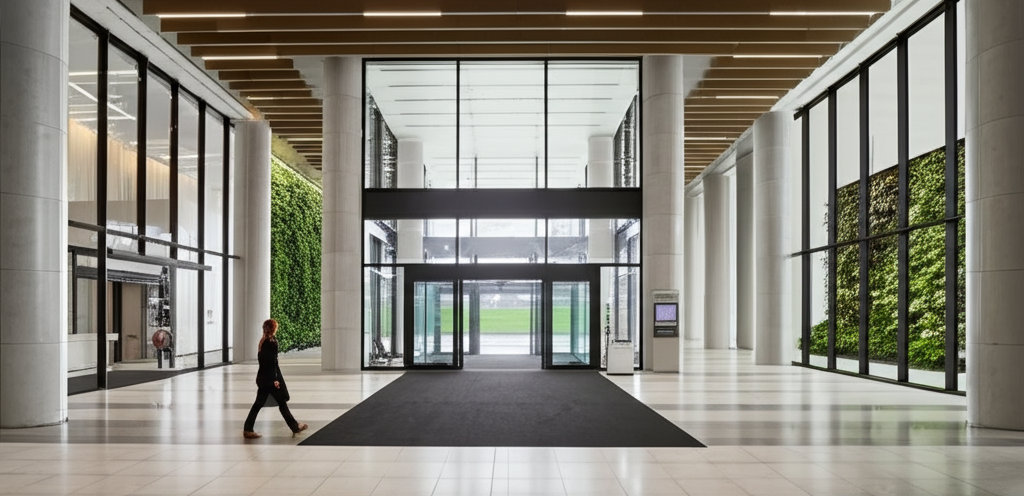

*A spacious, naturally lit lobby with a green wall and digital welcome signage.*

In [36]:
caption = "Main lobby entrance"
description = "A spacious, naturally lit lobby with a green wall and digital welcome signage."

img_path = generate_image_and_save(caption, description)

if img_path:
    # Display it
    display(Markdown(f"**Figure: {caption}**"))
    display(Image(filename=img_path, width=600))
    display(Markdown(f"*{description}*"))

### Raw Article

We first get the raw generated article from the few-shot prompting, and proceed to find all inserted image locations and replace them with AI generated images.

In [37]:
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[gen_rag_prompt] 
)
raw_article = response.text.strip()

print(raw_article)
Markdown('---')

# Designing for Wellness: How Return-to-Office Strategies Can Prioritize Employee Well-being
![A bright and airy office space featuring employees engaging in various wellness activities, such as yoga, meditation, and healthy eating, with an emphasis on natural light and biophilic design elements. — A spacious, modern office environment where employees are participating in wellness activities. Some are doing yoga on mats in a sunlit area, others are meditating in a quiet corner with plants, and a group is gathered around a table enjoying a healthy meal. The design incorporates large windows, natural materials, and greenery to promote a sense of calm and well-being.](GENERATE_IMAGE)
A bright and airy office space featuring employees engaging in various wellness activities, such as yoga, meditation, and healthy eating, with an emphasis on natural light and biophilic design elements.

As companies increasingly call for employees to return to the office, a critical question arises: How can 

---

Helper function to find and replace images in the raw article.

In [38]:
def replace_generate_image_markdown(article_text):
    """
    Replaces image placeholders with generated image markdown,
    or removes them entirely if generation fails.
    """
    pattern = re.compile(
        r'!\[(?P<description>.+?)\]\(GENERATE_IMAGE\)\s*\n(?P<caption>[^\n]+)',
        re.MULTILINE
    )

    def replacement(match):
        description = match.group('description').strip()
        caption = match.group('caption').strip()
        print(f"(Debug) Attempting to generate image for caption: {caption}")

        image_path = generate_image_and_save(caption, description)
        if image_path is None:
            print(f"(Debug) Image generation failed. Removing block for caption: {caption}")
            return ""  # Remove the entire block

        return f"![{description}]({image_path})\nCaption: {caption}"

    return pattern.sub(replacement, article_text)

Finally we process the image replacement and display it below:

In [39]:
updated_article = replace_generate_image_markdown(raw_article)

(Debug) Attempting to generate image for caption: A bright and airy office space featuring employees engaging in various wellness activities, such as yoga, meditation, and healthy eating, with an emphasis on natural light and biophilic design elements.
(Debug) Attempting to generate image for caption: A modern office layout showing different types of workspaces, including standing desks, ergonomic chairs, quiet rooms, and collaboration areas, with a focus on adjustable furniture and natural light.


In [40]:
display(Markdown('---'))
display(Markdown(updated_article))

---

# Designing for Wellness: How Return-to-Office Strategies Can Prioritize Employee Well-being
![A bright and airy office space featuring employees engaging in various wellness activities, such as yoga, meditation, and healthy eating, with an emphasis on natural light and biophilic design elements. — A spacious, modern office environment where employees are participating in wellness activities. Some are doing yoga on mats in a sunlit area, others are meditating in a quiet corner with plants, and a group is gathered around a table enjoying a healthy meal. The design incorporates large windows, natural materials, and greenery to promote a sense of calm and well-being.](generated_54d2330a.png)
Caption: A bright and airy office space featuring employees engaging in various wellness activities, such as yoga, meditation, and healthy eating, with an emphasis on natural light and biophilic design elements.

As companies increasingly call for employees to return to the office, a critical question arises: How can the workplace be designed to support and enhance employee well-being? The return-to-office (RTO) movement presents a unique opportunity to reimagine the work environment, placing wellness at the forefront of design considerations. By integrating wellness principles into office layouts, organizations can create spaces that not only accommodate work tasks but also nurture the physical, mental, and emotional health of their employees.

## The Shift Towards Wellness-Centric Design

The traditional office environment often prioritized productivity and efficiency, sometimes at the expense of employee well-being. Cubicle farms, fluorescent lighting, and limited access to nature contributed to stress, fatigue, and decreased job satisfaction. Today, there's a growing recognition that a healthy and happy workforce is a productive workforce. This realization has fueled a shift towards wellness-centric design, which seeks to create spaces that promote health, reduce stress, and enhance overall quality of life.

Wellness-centric design encompasses a variety of elements, including:

*   **Biophilic Design:** Incorporating natural elements like plants, natural light, and water features to connect employees with nature and reduce stress.
*   **Ergonomics:** Providing adjustable workstations, ergonomic chairs, and other tools to support physical comfort and prevent musculoskeletal issues.
*   **Activity-Based Workspaces:** Offering a range of work settings, from quiet focus rooms to collaborative hubs, to accommodate different tasks and work styles.
*   **Wellness Amenities:** Integrating amenities like fitness centers, meditation rooms, and healthy food options to support physical and mental well-being.
*   **Air Quality and Ventilation:** Ensuring proper ventilation and filtration to maintain clean and healthy indoor air quality.

## Integrating Wellness into the Return-to-Office Strategy

As companies plan their return-to-office strategies, it's crucial to integrate wellness considerations into the design and layout of the workplace. This involves rethinking traditional office spaces and creating environments that prioritize employee health and well-being.

![A modern office layout showing different types of workspaces, including standing desks, ergonomic chairs, quiet rooms, and collaboration areas, with a focus on adjustable furniture and natural light. — A detailed floor plan of a contemporary office space, showcasing a variety of work settings. The layout includes standing desks, ergonomic chairs, private focus rooms, open collaboration areas, and adjustable furniture. Large windows provide ample natural light, and the design incorporates elements of biophilic design, such as plants and natural materials.](generated_6d79ad20.png)
Caption: A modern office layout showing different types of workspaces, including standing desks, ergonomic chairs, quiet rooms, and collaboration areas, with a focus on adjustable furniture and natural light.

Here are some key strategies for integrating wellness into the return-to-office strategy:

1.  **Conduct a Wellness Audit:**
    Assess the current state of the workplace in terms of wellness. Identify areas that need improvement and gather feedback from employees on their needs and preferences.
2.  **Prioritize Natural Light and Views:**
    Maximize access to natural light and views of the outdoors. Natural light has been shown to improve mood, reduce eye strain, and enhance cognitive function.
3.  **Incorporate Biophilic Design:**
    Bring nature into the office through plants, green walls, and natural materials. Biophilic design can reduce stress, improve air quality, and create a more inviting and calming environment.
4.  **Create Activity-Based Workspaces:**
    Offer a variety of work settings to accommodate different tasks and work styles. This might include quiet focus rooms, collaborative hubs, standing desks, and informal lounge areas.
5.  **Invest in Ergonomic Furniture:**
    Provide adjustable workstations, ergonomic chairs, and other tools to support physical comfort and prevent musculoskeletal issues. Proper ergonomics can reduce strain and improve posture.
6.  **Promote Movement and Physical Activity:**
    Encourage movement throughout the day by providing walking paths, standing desks, and access to fitness facilities. Consider incorporating active workstations, such as treadmill desks or bike desks.
7.  **Offer Wellness Amenities:**
    Integrate amenities like fitness centers, meditation rooms, and healthy food options to support physical and mental well-being. These amenities can help employees prioritize their health and reduce stress.
8.  **Improve Air Quality and Ventilation:**
    Ensure proper ventilation and filtration to maintain clean and healthy indoor air quality. Poor air quality can lead to respiratory issues, fatigue, and decreased productivity.
9.  **Provide Mental Health Resources:**
    Offer access to mental health resources, such as counseling services, stress management programs, and mindfulness training. Supporting mental health is essential for overall well-being.
10. **Establish Wellness Policies:**
    Implement policies that support employee well-being, such as flexible work arrangements, paid time off for mental health, and wellness programs.

## The Benefits of Wellness-Centric Design

Investing in wellness-centric design can bring significant benefits to both employees and organizations. These include:

*   **Improved Employee Health and Well-being:**
    Wellness-centric design can reduce stress, improve mood, enhance physical comfort, and promote overall well-being.
*   **Increased Productivity and Engagement:**
    Healthy and happy employees are more productive and engaged in their work. Wellness-centric design can boost morale, motivation, and job satisfaction.
*   **Reduced Absenteeism and Healthcare Costs:**
    By promoting health and preventing illness, wellness-centric design can reduce absenteeism and lower healthcare costs.
*   **Enhanced Recruitment and Retention:**
    A workplace that prioritizes employee well-being can attract top talent and retain valuable employees.
*   **Stronger Company Culture:**
    Wellness-centric design can foster a positive and supportive company culture, where employees feel valued and cared for.

## Conclusion

The return to the office presents a unique opportunity to reimagine the workplace and prioritize employee well-being. By integrating wellness principles into office design, organizations can create spaces that not only accommodate work tasks but also nurture the physical, mental, and emotional health of their employees. Investing in wellness-centric design can bring significant benefits, including improved employee health, increased productivity, reduced costs, and a stronger company culture. As companies navigate the return to the office, it's essential to prioritize wellness and create environments that support the well-being of their workforce.

## Time to bring everything together

### Levereraging Gemini's multi modal and function calling capabilities, we can string all the previously achieved functionalities together

But first we need to cleanly organize our functions so it's not fragmented and wrapped.

In [ ]:
# Image search
def display_filtered_image_results(query: str, top_k: int, max_distance: float) -> str:
    """Search image DB and return Markdown-formatted visual results."""
    image_embed_fn.document_mode = False
    result = image_db.query(query_texts=[query], n_results=top_k)

    keep_indices = [i for i, dist in enumerate(result["distances"][0]) if dist <= max_distance]

    filtered_result = {}
    for key, value in result.items():
        if isinstance(value, list) and len(value) > 0 and isinstance(value[0], list):
            filtered_result[key] = [[value[0][i] for i in keep_indices]]
        else:
            filtered_result[key] = value

    markdown_results = []
    for i in range(len(filtered_result["documents"][0])):
        caption = filtered_result["documents"][0][i]
        meta = filtered_result["metadatas"][0][i]
        image_url = meta["image_url"]
        title = meta.get("title", "Untitled")
        source_url = meta.get("source", "#")

        markdown_results.append(
            f"### Image {i+1} — *{title}*\n"
            f"![{caption}]({image_url})\n"
            f"**Caption:** {caption}  \n"
            f"[From article: *{title}*]({source_url})\n---"
        )

    return "\n\n".join(markdown_results)


In [ ]:
# Article Search
def search_articles_with_filter(query: str, top_k: int, max_distance: float) -> str:
    """
    Search the article Chroma DB and return relevant content as Markdown.
    """
    embed_fn.document_mode = False
    result = db.query(query_texts=[query], n_results=top_k)

    keep_indices = [
        i for i, dist in enumerate(result["distances"][0]) if dist <= max_distance
    ]

    filtered_result = {}
    for key, value in result.items():
        if isinstance(value, list) and len(value) > 0 and isinstance(value[0], list):
            filtered_result[key] = [[value[0][i] for i in keep_indices]]
        else:
            filtered_result[key] = value

    markdown_results = []
    for i in range(len(filtered_result["documents"][0])):
        doc = filtered_result["documents"][0][i]
        meta = filtered_result["metadatas"][0][i]
        title = meta.get("title", f"Result {i+1}")
        source = meta.get("source", "#")

        excerpt = doc.strip()[:2000]
        markdown_results.append(
            f"### {i+1}. *{title}*\n\n"
            f"{excerpt}...\n\n"
            f"📎 [Read full article]({source})\n---"
        )

    return "\n\n".join(markdown_results)

In [ ]:
# Image generation
def generate_image_with_caption(caption: str, description: str) -> str:
    """
    Generates an architectural image based on a caption and detailed description.
    Returns: Markdown block with the image and description.
    """
    from PIL import Image as PILImage
    from IPython.display import Markdown, Image, display
    
    prompt = f"""
    Please generate an image with a landscape aspect ratio, 
    the types of images you would find on the website of professional architecture firm's website,
    specifically on Gensler's (architectural design firm) website,
    with highest quality, in professional photography or professional rendering style
    photo realistic and with intricate and sufficient detail,
    also matching the description below, if it's not mentioned below, put in at least one or two person: 
    {caption}. {description}
    """

    try:
        response = client.models.generate_content(
            model="gemini-2.0-flash-exp-image-generation",
            contents=[prompt],
            config=genai.types.GenerateContentConfig(
                response_modalities=["TEXT", "IMAGE"]
            )
        )

        for part in response.candidates[0].content.parts:
            if part.text is not None:
                print(f"(Debug) Generated text: {part.text}")
            elif part.inline_data is not None:
                image = PILImage.open(BytesIO(part.inline_data.data))
                path = f"generated_{uuid.uuid4().hex[:8]}.png"
                full_path = f"/kaggle/working/{path}"
                image.save(full_path)

                # Display in notebook
                display(Markdown(f"**Figure: {caption}**"))
                display(Image(filename=full_path, width=800))
                display(Markdown(f"*{description}*"))

                return f"🖼️ Image saved and rendered in notebook: `{full_path}`"

        raise ValueError("No image returned.")

    except Exception as e:
        print(f"(Debug) Image generation failed: {e}")
        return "⚠️ Image generation failed."

In [ ]:
# RAG generation - Article Summarization
class AnswerWithCitations(TypedDict):
    answer: str
    citations: List[int]

def summarize_with_sources(query: str, top_k: int, max_distance: float) -> str:
    """
    Perform a RAG query and structured summarization of database articles.
    Returns markdown-formatted answer with footnotes.
    """
    # Step 1: Retrieve filtered results
    result = search_chroma(query, top_k=top_k)
    keep_indices = [i for i, d in enumerate(result["distances"][0]) if d <= max_distance]

    # Step 2: Build prompt with selected articles
    filtered_result = {k: [[v[0][i] for i in keep_indices]] if isinstance(v, list) and len(v) > 0 and isinstance(v[0], list) else v for k, v in result.items()}
    rag_prompt, structured_articles = build_rag_prompt(system_prompt, query, output_format, result=filtered_result)

    # Step 3: Define schema + config for structured return
    structured_config = types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=AnswerWithCitations,
        temperature=0.1
    )

    # Step 4: Run Gemini generation
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        config=structured_config,
        contents=[rag_prompt]
    )

    structured = response.parsed
    used_ids = set(structured["citations"])

    # Step 5: Format footnotes
    footnotes = "\n".join(
        f"[{a['ref_id']}]: [{a['title']}]({a['url']}) | Relevance: {(1 - a['distance']) * 100:.1f}%"
        for a in structured_articles if a["ref_id"] in used_ids
    )

    final_output = f"{structured['answer']}\n\n---\n**References**\n\n{footnotes}"
    display(Markdown(final_output))

In [ ]:
# RAG generation - Article generation
def generate_article_with_images(gen_query: str, top_k: int) -> str:
    """
    Generates a thought leadership article using few-shot prompting and inserts images.
    Returns a complete Markdown-formatted article.
    """

    # Step 1: Build few-shot prompt
    gen_rag_prompt = build_few_shot_prompt(gen_sys_prompt, gen_query, gen_output_format, top_k=top_k)

    # Step 2: Generate article content
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=[gen_rag_prompt]
    )
    raw_article = response.text.strip()

    # Step 3: Replace image placeholders with actual image markdown
    def replace_generate_image_markdown(article_text):
        pattern = re.compile(
            r'!\[(?P<description>.+?)\]\(GENERATE_IMAGE\)\s*\n(?P<caption>[^\n]+)',
            re.MULTILINE
        )

        def replacement(match):
            description = match.group('description').strip()
            caption = match.group('caption').strip()
            print(f"(Debug) Generating image for: {caption}")
            image_path = generate_image_and_save(caption, description)
            if image_path is None:
                return ""  # Remove placeholder if image gen fails
            return f"![{description}]({image_path})\n*{caption}*"

        return pattern.sub(replacement, article_text)

    updated_article = replace_generate_image_markdown(raw_article)

    # Step 4: Display and return result
    display(Markdown("---"))
    display(Markdown(updated_article))

We can now create Gemini Assistant with tools

In [ ]:
tools = [
    search_articles_with_filter,
    display_filtered_image_results,
    generate_image_with_caption,
    summarize_with_sources,
    generate_article_with_images
]

instruction = """you're a helpful assitant that can interact with databases
set up in ChromaDB. You will take the user's questions and turn them into queries
using the tools available. Once you have the information you need, you must use its return value directly in your response without paraphrasing or summarizing it. This is very very important.
Always show the full content from the tool result so the user sees the images and article links.

Use search_articles_with_filter to query articles from the database (When calling the article search tool, 
ALWAYS request at least 5 results using a top_k value of 5 and a max_distance of 0.85 unless the user 
specifies otherwise.). 

Use display_filtered_image_results to search and display images from the database (When calling the image 
search tool, ALWAYS request at least 5 results using a top_k value of 5 and a max_distance of 0.99 
unless the user specifies otherwise.). 

When a user asks for an explanation, summary, analysis, or strategic insight, call the summarize_with_sources tool
(When calling the summarize_with_sources tool, ALWAYS request at least 5 results using a top_k value of 5 and a max_distance of 0.85 
unless the user specifies otherwise.).This tool will search the article database, retrieve relevant documents, and generate a 
structured answer in the style of bullet points with citations. 
Return the tool output directly without summarizing or rephrasing it.

When the user asks for a new article to be written, use the generate_article_with_images tool to generate a thought leadership
article for the AEC industry. (When calling the generate_article_with_images, ALWAYS use a top_k value of 5 unless the user specifies otherwise.)
This generate_article_with_images tool will Retrieve relevant articles from a proprietary database as few-shot examples,
Generate a new article using those examples, and Automatically insert well-placed visuals with captions and descriptions. Use the tool’s output directly 
in your response. Do not rewrite, paraphrase, or summarize it. If visuals are included, render them inline with their descriptions and captions.
Only use this tool for full article generation requests, not for quick answers or summaries.

When the user requests a new image, call generate_image_with_caption with their caption and description.
Use the output directly in your reply."""

chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=tools,
        tool_config=types.ToolConfig(
            function_calling_config={"mode": "auto"}
        )
    ),
)

**Image search**

In [ ]:
query = "Show me images related to office space."
response = chat.send_message(query)
display(Markdown(response.text.strip()))

**article search**

In [ ]:
query = "show me articles related to mixed use development."
response = chat.send_message(query)
display(Markdown(response.text.strip()))

**image generation**

In [ ]:
response = chat.send_message("Create an image of a pedestrian-friendly urban square with restaurants and trees.")
display(Markdown(response.text.strip()))

**RAG - Answer a question**

In [ ]:
answer = chat.send_message("Provide me issues to think about when designing for return to office space.")

**RAG - Generate an article**

In [ ]:
article = chat.send_message("Generate a thought leadership article on the intersection between return-to-office design and wellness in the work place.")